In [96]:
import numpy as np

# Percorsi ai file
X = np.load("dataset_75/images.npy")
y = np.load("dataset_75/labels.npy")

X = X.astype("float32") / 255.0

X = X[..., np.newaxis]

print(X.shape)  # es. (18000, 150, 150) o (18000, 75, 75)
print(y.shape)  # es. (18000, 2)



(18000, 75, 75, 1)
(18000, 2)


In [97]:
label=y[:,0]+y[:,1]/60
print(label[15500])     
print(y[15500])

import tensorflow as tf

def custom_accuracy(y_true, y_pred):
    diff = tf.minimum(tf.abs(y_true - y_pred), tf.abs(12 - tf.abs(y_true - y_pred)))
    return tf.reduce_mean(tf.cast(diff < 0.5, tf.float32))



10.333333333333334
[10 20]


In [98]:
from sklearn.model_selection import train_test_split

X_traina, X_test, y_traina, y_test = train_test_split(X, label, test_size=0.1, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_traina, y_traina, test_size=y_test.shape[0], random_state=42, shuffle=True)

print(X_test.shape)
print(X_val.shape)
print(X_train.shape)
print(X_train[0].shape)

(1800, 75, 75, 1)
(1800, 75, 75, 1)
(14400, 75, 75, 1)
(75, 75, 1)


In [99]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras import layers, models, regularizers
from keras.optimizers import AdamW
from keras.callbacks import ReduceLROnPlateau


In [ ]:
model_base = models.Sequential([
    keras.layers.Conv2D(32, (5,5), padding="same", input_shape=X_train[0].shape, kernel_initializer="he_uniform"),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.3),

    keras.layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.AveragePooling2D(2,2),
    #keras.layers.Dropout(0.3),

    keras.layers.Conv2D(128, (3,3), padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.AveragePooling2D(2,2),
    keras.layers.Dropout(0.3),

    #keras.layers.Conv2D(256, (3,3), padding="same", activation="relu"),
    #keras.layers.BatchNormalization(),
    #keras.layers.AveragePooling2D(2,2),
    #keras.layers.Dropout(0.3),    

    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-4)),
    keras.layers.Dropout(0.3),
    #keras.layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(1e-4)),
    #keras.layers.Dropout(0.3),
    #keras.layers.Dense(32, activation="relu", kernel_regularizer=regularizers.l2(1e-4)),
    #keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation="linear")
    
])

/vol/home/s4949404/miniconda3/envs/IDL/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [101]:
class MyCustomLoss(tf.keras.losses.Loss):
    def call(self, y_true, y_pred):
        return tf.reduce_mean(tf.minimum(tf.abs(y_true-y_pred), tf.abs(12-tf.abs(y_true-y_pred))))  # MAE personalizzato


In [102]:
model_base.compile(
    optimizer=AdamW(learning_rate=1e-3, weight_decay=5e-5),
    loss=MyCustomLoss(),
    metrics=[custom_accuracy]
)

In [103]:
# Reduce LR when validation loss stops improving
lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6
)

checkpoint = keras.callbacks.ModelCheckpoint(
    "best_model.keras",
    save_best_only=True
)

early_stopping=keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True
)

In [104]:
history_base = model_base.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[lr_scheduler,checkpoint,early_stopping]
)


Epoch 1/50


225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - custom_accuracy: 0.0841 - loss: 3.0001 - val_custom_accuracy: 0.0828 - val_loss: 3.0504 - learning_rate: 0.0010
Epoch 2/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - custom_accuracy: 0.0838 - loss: 3.0056 - val_custom_accuracy: 0.0695 - val_loss: 3.0568 - learning_rate: 0.0010
Epoch 3/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - custom_accuracy: 0.0833 - loss: 3.0008 - val_custom_accuracy: 0.0862 - val_loss: 3.0474 - learning_rate: 0.0010
Epoch 4/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - custom_accuracy: 0.0850 - loss: 2.9992 - val_custom_accuracy: 0.0860 - val_loss: 3.0402 - learning_rate: 0.0010
Epoch 5/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - custom_accuracy: 0.0839 - loss: 3.0099 - val_custom_accuracy: 0.0812 - val_loss: 3.0309 - learning_rate: 0.0010
Epoch 6/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - custom_accuracy: 0.0825 - loss: 3.0065 - val_custom_accuracy: 0.0891 - val_loss: 3.0361 - learning_rate: 0.0010
Epoch 7/50
225

In [105]:
# Carichiamo il modello salvato con i pesi migliori
best = keras.models.load_model("best_model.keras")

# Valutiamo sul test set
test_loss, test_acc = best.evaluate(X_train, y_train)
print(f"Loss sul train set: {test_loss:.4f}")
print(f"Accuratezza sul train set: {test_acc:.4f}")

# Valutiamo sul test set
test_loss, test_acc = best.evaluate(X_test, y_test)
print(f"Loss sul test set: {test_loss:.4f}")
print(f"Accuratezza sul test set: {test_acc:.4f}")

TypeError: Could not locate class 'MyCustomLoss'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': None, 'class_name': 'MyCustomLoss', 'config': {'name': 'my_custom_loss_9', 'reduction': 'sum_over_batch_size'}, 'registered_name': 'MyCustomLoss'}

In [ ]:
"""y_pred = model_base.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_classes)
ConfusionMatrixDisplay(cm).plot()"""




57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


ValueError: Classification metrics can't handle a mix of continuous and binary targets

NameError: name 'history_base' is not defined

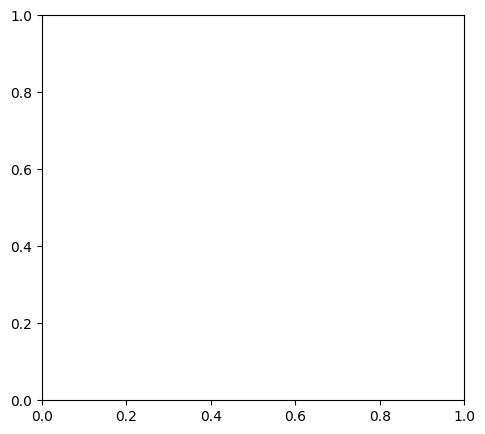

In [ ]:
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_base.history["accuracy"], label="Train")
plt.plot(history_base.history["val_accuracy"], label="Validation")
plt.title("Accuratezza")
plt.xlabel("Epoca")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_base.history["loss"], label="Train")
plt.plot(history_base.history["val_loss"], label="Validation")
plt.title("Loss")
plt.xlabel("Epoca")
plt.ylabel("Loss")
plt.legend()

plt.show()